In [87]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from copy import deepcopy
from sklearn.externals import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import graphviz
import warnings
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

In [88]:
#不重要的警告信息不予显示

#warnings.filterwarnings("ignore")

# 1 特征处理

In [89]:
data_path=r'D:\study\Competition\porto-sequro-safe-driver-prediction\data'
train_df=pd.read_csv(data_path+'\\train.csv',na_values=-1)
test_df=pd.read_csv(data_path+'\\test.csv',na_values=-1)

In [90]:
#所有二元变量
bin_features=[feat for feat in train_df.columns if 'bin' in feat]
#所有的分类变量
cat_features=[feat for feat in train_df.columns if 'cat' in feat]
#所有calc变量
calc_features=[feat for feat in train_df.columns if 'calc' in feat]

In [91]:
train_df.head(3)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0


### One_Hot_Encoding

### 每一个分类变量的缺失值我们用'最大值+1'来填充

In [92]:
oht_feat=pd.get_dummies(train_df[cat_features].append(test_df[cat_features]),columns=cat_features,dummy_na=True)

In [93]:
train_df=train_df.join(oht_feat.iloc[0:train_df.shape[0]])
test_df=test_df.join(oht_feat.iloc[train_df.shape[0]:])

### 方差为0（或取值唯一）的变量

In [94]:
useless_feats=list(train_df.columns[train_df.var()==0])

In [95]:
use_features=[x for x in train_df.columns if x not in ['id','target']+cat_features+useless_feats]

In [96]:
train_df_lgb,train_df_lr=train_test_split(train_df,test_size=0.60,stratify=train_df['target'],random_state=9)

In [107]:
X_lgb=train_df_lgb[use_features]
y_lgb=train_df_lgb['target']

X_lr=train_df_lr[use_features]
y_lr=train_df_lr['target']

X_predict=test_df[use_features]

In [98]:
X_train_lgb,X_test_lgb,y_train_lgb,y_test_lgb=train_test_split(X_lgb,y_lgb,test_size=0.20,stratify=y_lgb,random_state=9)

In [100]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() 

def gini_normalized(preds,dtrain):
    y=dtrain.get_label()
    preds=softmax(preds)
    return 'NormGini',gini(y, preds) / gini(y, y),True

def gini_normalized_ordinary(y,preds):
    return gini(y, preds) / gini(y, y)

def modelfit(alg,X,y,X_test,y_test,cat_features,cvparams,folds=None,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    feature_names=list(X.columns)
    if useTrainCV==True:
        dtrain=lgb.Dataset(X, label=y, max_bin=255, reference=None, 
                           weight=None, group=None, silent=False, feature_name=feature_names,
                            categorical_feature=cat_features,params=None, free_raw_data=True)
        cvresult=lgb.cv(cvparams,dtrain,num_boost_round=50000,folds=folds,nfold=cv_folds,stratified=True,
                        metrics='auc',feature_name=feature_names,categorical_feature=cat_features,early_stopping_rounds=early_stopping_rounds,
                        verbose_eval=20,show_stdv =True,seed=9)
        #,feval=gini_normalized
        alg.set_params(n_estimators=len(cvresult['auc-mean']))
        print('Best Iteration:',len(cvresult['auc-mean']))
        
    alg.fit(X,y,eval_metric='auc',feature_name=feature_names,categorical_feature=cat_features)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    dtrain_predprob=alg.predict_proba(X)[:,1]
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    dtest_predprob=alg.predict_proba(X_test)[:,1]
    
    #Print Mode report:
    print('Model report on trian:')
    #print('Train Accuracy:{0:.4f}'.format(metrics.accuracy_score(y,dtrain_predictions)))
    print('Train AUC:{0:.4f}'.format(metrics.roc_auc_score(y,dtrain_predprob)))
    #print('Train Normalized GINI：{0:.6f}'.format(gini_normalized_ordinary(y,dtrain_predprob)))
    print('Model report on test:')
    #print('Test Accuracy:{0:.4f}'.format(metrics.accuracy_score(y_test,dtest_predictions)))
    print('Test AUC:{0:.4f}'.format(metrics.roc_auc_score(y_test,dtest_predprob)))
    #print('Test Normalized GINI：{0：.6f}'.format(gini_normalized_ordinary(y,dtest_predprob)))
    print('Test classifiction report:')
    print(metrics.classification_report(y_test,dtest_predictions))
    print('Test confusion matrix:')
    plt.figure()
    with sns.axes_style(style='dark'):
        plot_confusion_matrix(metrics.confusion_matrix(y_test,dtest_predictions),classes=['0','1'],
                             title='Confusion Matrix')
    
    feat_imp=pd.Series(alg.feature_importances_,index=X.columns).sort_values(ascending=True)
    #plt.figure()
    #feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    #plt.ylabel('Feature Importance Score')
    lgb.plot_importance(alg,importance_type='split')
    return feat_imp

def turnParams_general(model,X,y,searchParam,modelparams,scoring='roc_auc',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y,eval_metric='auc')
    param_name=list(searchParam.keys())[0]
    columns=[p[param_name] for p in gsc.cv_results_['params']]
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score'],
                            columns=columns).T
    #cv_scores.index.name=param_name
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)

def turnParams(model,X,y,cat_features,searchParam,modelparams,scoring='roc_auc',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y,eval_metric='auc',categorical_feature=cat_features)
    param_name=list(searchParam.keys())[0]
    columns=[p[param_name] for p in gsc.cv_results_['params']]
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score'],
                            columns=columns).T
    #cv_scores.index.name=param_name
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 1.1 训练用于生成新特征的lgb模型

In [101]:
params={'boosting_type': 'gbdt',
 'colsample_bytree': 1.0,
 'is_unbalance': True,
 'learning_rate': 0.05,
 'max_bin': 255,
 'max_depth': 6,
 'min_child_samples': 1,
 'min_child_weight': 0,
 'min_split_gain': 0,
 'n_estimators': 162,
 'n_jobs': 4,
 'num_leaves': 10,
 'objective': 'binary',
 'random_state': 9,
 'reg_alpha': 37.2,
 'reg_lambda': 0.002,
 'subsample': 0.95,
 'subsample_freq': 1}

cvparams={'bagging_fraction': 0.95,
 'bagging_freq': 1,
 'boosting_type': 'gbdt',
 'feature_fraction': 1.0,
 'is_unbalance': True,
 'lambda_l1': 37.2,
 'lambda_l2': 0.002,
 'learning_rate': 0.05,
 'max_bin': 255,
 'max_depth': 6,
 'min_data_in_leaf': 1,
 'min_gain_to_split': 0,
 'min_sum_hessian_in_leaf': 0,
 'num_leaves': 20,
 'num_threads': 4,
 'objective': 'binary'}
#在sklaearn接口中，参数名称发生了变化，需要进行映射
tran_table={ 'min_split_gain':'min_gain_to_split',
             'min_child_weight':'min_sum_hessian_in_leaf',
             'min_child_samples':'min_data_in_leaf',
             'subsample':'bagging_fraction',
             'subsample_freq':'bagging_freq',
             'colsample_bytree':'feature_fraction',
             'reg_alpha':'lambda_l1',
             'reg_lambda':'lambda_l2',
             'n_jobs':'num_threads',
            
             'boosting_type':'boosting_type',
             'num_leaves':'num_leaves',
             'max_depth':'max_depth',
             'learning_rate':'learning_rate',
             'max_bin':'max_bin',
             'objective':'objective',
             'is_unbalance':'is_unbalance'}
def get_lgb_params(sklearn_params,cvparams,tran_table):
    for sklearn_param,lgb_param in tran_table.items():
        cvparams[lgb_param]=sklearn_params[sklearn_param]

In [102]:
params['learning_rate']=0.3

In [103]:
lgbc=lgb.LGBMClassifier(**params)

[20]	cv_agg's auc: 0.632687 + 0.0091107
[40]	cv_agg's auc: 0.631014 + 0.00757561
[60]	cv_agg's auc: 0.628684 + 0.00650633
Best Iteration: 22
Model report on trian:
Train AUC:0.6675
Model report on test:
Test AUC:0.6284
Test classifiction report:
             precision    recall  f1-score   support

          0       0.97      0.63      0.77     45881
          1       0.05      0.56      0.10      1736

avg / total       0.94      0.63      0.74     47617

Test confusion matrix:
Confusion matrix, without normalization
[[29087 16794]
 [  768   968]]


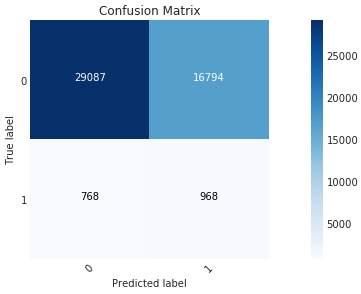

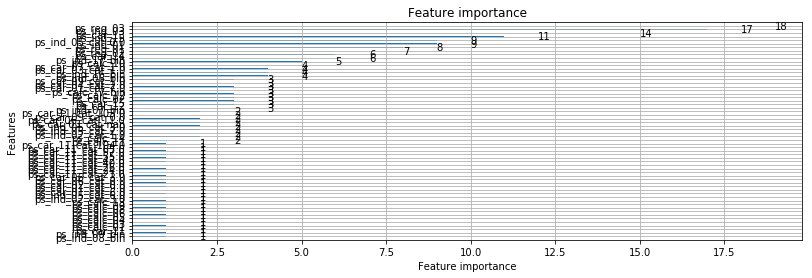

In [104]:
get_lgb_params(params,cvparams,tran_table)

feat_imp=modelfit(lgbc,X_train_lgb,y_train_lgb,X_test_lgb,y_test_lgb,'auto',cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=50)

In [83]:
#lgb.create_tree_digraph(lgbc)

In [105]:
params['n_estimators']=22

## 1.2 利用LGBM生成新特征（样本在各个树中叶子节点编号）

In [106]:
lgbc_final=lgb.LGBMClassifier(**params)

In [108]:
lgbc_final.fit(X_lgb,y_lgb,feature_name=list(X_lgb.columns),categorical_feature='auto')

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, is_unbalance=True,
        learning_rate=0.3, max_bin=255, max_depth=6, min_child_samples=1,
        min_child_weight=0, min_split_gain=0, n_estimators=22, n_jobs=4,
        num_leaves=10, objective='binary', random_state=9, reg_alpha=37.2,
        reg_lambda=0.002, silent=True, subsample=0.95,
        subsample_for_bin=50000, subsample_freq=1)

In [36]:
tree_cnt=lgbc_final.get_params()['n_estimators']
lgb_feat_name=['tree_'+str(i) for i in range(1,tree_cnt+1)]

In [109]:
def get_lgb_feat(X,X_predict,lgbc):
    tree_cnt=lgbc.get_params()['n_estimators']
    lgb_feat_name=['tree_'+str(i) for i in range(1,tree_cnt+1)]
    #获取各样本在叶子节点的编号
    lgb_idx_X=pd.DataFrame(lgbc.apply(X,num_iteration=tree_cnt),columns=lgb_feat_name,index=X.index)
    lgb_idx_X_predict=pd.DataFrame(lgbc.apply(X_predict,num_iteration=tree_cnt),columns=lgb_feat_name,index=X_predict.index)
    #对各变量哑编码
    dummy_feat=pd.get_dummies(lgb_idx_X.append(lgb_idx_X_predict),columns=lgb_feat_name,drop_first=True)
    X_new=X.join(dummy_feat.iloc[0:X.shape[0]])
    X_predict_new=X_predict.join(dummy_feat.iloc[X.shape[0]:])
    return X_new,X_predict_new

In [110]:
X_lr,X_predict=get_lgb_feat(X_lr,X_predict,lgbc_final)

In [111]:
X_lr.fillna(-1,inplace=True)
X_predict.fillna(-1,inplace=True)

### 归一化,由于二元变量、哑编码变量取值范围都是取值范围在[0,1]区间，所以可以不用归一化，中心化只是影响参数的偏移量，对模型结果没有影响

In [113]:
for feat in X_lr.columns:
    cat_f='cat' in feat
    tree_f='tree' in feat
    bin_f='bin' in feat
    norm_flag=not cat_f|tree_f|bin_f
    if norm_flag:
        std_v=X_lr[feat].std()
        mean_v=X_lr[feat].mean()
        X_lr[feat]=(X_lr[feat]-mean_v)/std_v
        X_predict[feat]=(X_predict[feat]-mean_v)/std_v

In [114]:
X_train,X_test,y_train,y_test=train_test_split(X_lr,y_lr,test_size=0.20,stratify=y_lr,random_state=9)

# 2 LR模型训练

In [115]:
lr_params={'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': 9,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [116]:
lr=LogisticRegression(**lr_params)

In [117]:
cross_val_score(lr,X_lr,y_lr,scoring='roc_auc',cv=5)

array([ 0.62569989,  0.62744894,  0.6336314 ,  0.63104699,  0.64184404])

In [118]:
lr_final=LogisticRegression(**lr_params)
lr_final.fit(X_lr,y_lr)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=9,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# 2 Tune params

In [119]:
pred_prob=lr_final.predict_proba(X_predict)[:,1]

In [120]:
predict_result=pd.DataFrame({'id':test_df['id'].astype(int),'target':pd.Series(pred_prob,index=test_df['id'].index)})

In [121]:
predict_result.head()

,id,target
0,0,0.456649
1,1,0.342196
2,2,0.433192
3,3,0.268797
4,4,0.547569


In [122]:
predict_result.to_csv(r'D:\study\Competition\kaggle-PSSDP-20171014\20171103_16lgbm_LR2.csv',index=False)

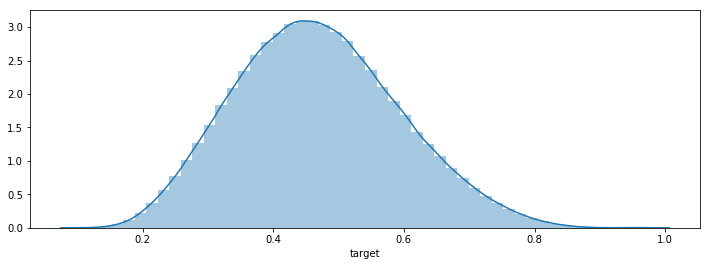

In [123]:
sns.distplot(predict_result['target'])

In [124]:
predict_result['target'].describe()

count    892816.000000
mean          0.468302
std           0.125049
min           0.100312
25%           0.378135
50%           0.462590
75%           0.551959
max           0.980751
Name: target, dtype: float64